# Tensorflow Official Tutorial Site
###### https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=ko

# Import libraries

In [1]:
import numpy as np # Mathematical Package
import pandas as pd # DataFrame Package
import tensorflow as tf # Deeplearning Package

import warnings
warnings.filterwarnings(action='ignore')

print("The version of packages")
print(np.__version__)
print(pd.__version__)
print(tf.__version__)

The version of packages
1.16.5
0.25.1
2.0.0


In [2]:
# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Download Heart_disease Data
|Column|Description|Feature Type|Data Type|
|:-----------|:-----------|:-----------|:-----------|
|Age|Age in years|Numerical|integer|
|Sex|(1 = male; 0 = female)|Categorical|integer|
|CP|Chest pain type (0, 1, 2, 3, 4)|Categorical|integer|
|Trestbpd|Resting blood pressure (in mm Hg on admission to the hospital)|Numerical|integer|
|Chol|Serum cholestoral in mg/dl|Numerical|integer|
|FBS|(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|Categorical|integer|
|RestECG|Resting electrocardiographic results (0, 1, 2)|Categorical|integer|
|Thalach|Maximum heart rate achieved|Numerical|integer|
|Exang|Exercise induced angina (1 = yes; 0 = no)|Categorical|integer|
|Oldpeak|ST depression induced by exercise relative to rest|Numerical|float|
|Slope|The slope of the peak exercise ST segment|Numerical|integer|
|CA|Number of major vessels (0-3) colored by flourosopy|Numerical|integer|
|Thal|3 = normal; 6 = fixed defect; 7 = reversable defect|Categorical|string|
|Target|Diagnosis of heart disease (1 = true; 0 = false)|Categorical|integer|


In [3]:
url ='https://storage.googleapis.com/applied-dl/heart.csv'
df = pd.read_csv(url)
# target = df.pop('target')
print(df.shape)

df.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


# 1. Transform categorical features as one-hot vector

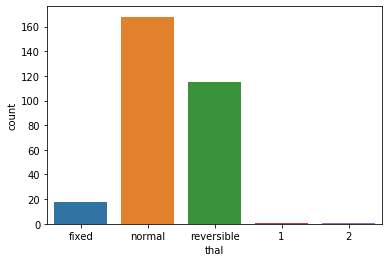

In [4]:
df['thal'].value_counts()
sns.countplot(df['thal'])
plt.show()

In [6]:
df = pd.concat([df, pd.get_dummies(df['cp'],prefix='cp')],axis=1).drop(['cp'],axis=1)
df = pd.concat([df, pd.get_dummies(df['sex'],prefix='sex')],axis=1).drop(['sex'],axis=1)
df = pd.concat([df, pd.get_dummies(df['thal'],prefix='thal')],axis=1).drop(['thal'],axis=1)
df.drop('thal_1',axis=1)
df.drop('thal_2',axis=1)
df.head()

,age,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,...,cp_2,cp_3,cp_4,sex_0,sex_1,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,1,2,150,0,2.3,3,0,...,0,0,0,0,1,0,0,1,0,0
1,67,160,286,0,2,108,1,1.5,2,3,...,0,0,1,0,1,0,0,0,1,0
2,67,120,229,0,2,129,1,2.6,2,2,...,0,0,1,0,1,0,0,0,0,1
3,37,130,250,0,0,187,0,3.5,3,0,...,0,1,0,0,1,0,0,0,1,0
4,41,130,204,0,2,172,0,1.4,1,0,...,1,0,0,1,0,0,0,0,1,0


## 2. Split the DataFrame into Train, Test, Validation 

In [7]:
from sklearn.model_selection import train_test_split

sample_size = df.shape[0]

train_idx, test_idx = train_test_split(range(sample_size), test_size = 0.3)
val_idx, test_idx = train_test_split(test_idx, test_size = 0.5)

# By splitting index, it can preserve index and columns

train = df.iloc[train_idx]
test = df.iloc[test_idx]
val = df.iloc[val_idx]

print('The number of Train \t',len(train))
print('The number of Val\t',len(val))
print('The number of Test \t',len(test))

train.head()

The number of Train 	 212
The number of Val	 45
The number of Test 	 46


,age,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,...,cp_2,cp_3,cp_4,sex_0,sex_1,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
226,57,110,335,0,0,143,1,3.0,2,1,...,0,0,1,0,1,0,0,0,0,1
278,60,140,185,0,2,155,0,3.0,2,0,...,0,1,0,0,1,0,0,0,1,0
167,41,112,268,0,2,172,1,0.0,1,0,...,0,1,0,1,0,0,0,0,1,0
207,44,118,242,0,0,149,0,0.3,2,1,...,0,1,0,1,0,0,0,0,1,0
238,63,140,187,0,2,144,1,4.0,1,2,...,0,0,1,0,1,0,0,0,0,1


## 3. Make the input pipeline

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size = 32):
    df = dataframe.copy()
    labels = df.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((df.values, labels.values))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(df))
        
    ds = ds.batch(batch_size)
    
    return ds

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [9]:
example_batch = next(iter(train_ds))[0]
print(example_batch)

tf.Tensor(
[[5.20e+01 1.08e+02 2.33e+02 1.00e+00 0.00e+00 1.47e+02 0.00e+00 1.00e-01
  1.00e+00 3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00
  1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]
 [4.90e+01 1.20e+02 1.88e+02 0.00e+00 0.00e+00 1.39e+02 0.00e+00 2.00e+00
  2.00e+00 3.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]
 [6.80e+01 1.80e+02 2.74e+02 1.00e+00 2.00e+00 1.50e+02 1.00e+00 1.60e+00
  2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]
 [4.50e+01 1.15e+02 2.60e+02 0.00e+00 2.00e+00 1.85e+02 0.00e+00 0.00e+00
  1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00
  1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00]
 [6.70e+01 1.52e+02 2.12e+02 0.00e+00 2.00e+00 1.50e+02 0.00e+00 8.00e-01
  2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  1.00e+00 0.00e+00 0

## 4. Build Model
- Functional API Model
- Neural Network

In [10]:
from tensorflow.keras.layers import Dense,  Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid


input_shape = train.shape[1] -1

def Dense_net(input_shape = input_shape):
    
    inputs = tf.keras.Input(shape=(input_shape))
    
    fc1 = Dense(units=512, activation='relu')(inputs)
    drop1 = Dropout(0.2)(fc1)
    
    fc2 = Dense(units=512, activation='relu')(drop1)
    drop2 = Dropout(0.2)(fc2)
    
    fc3 = Dense(units=256, activation='relu')(drop2)
    drop3 = Dropout(0.2)(fc3)
    
    fc4 = Dense(units=256, activation='relu')(drop3)
    drop4 = Dropout(0.2)(fc4)
    
    logits = Dense(units=1)(drop4)
    outputs = sigmoid(logits)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = Dense_net(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               11776     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0     

## 5. Loss & Optimizer

In [11]:
lr=0.001

loss = tf.keras.losses.binary_crossentropy
adam = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss = loss,
              optimizer = adam,
              metrics= ['accuracy'])

In [12]:
epochs = 30

hist = model.fit(train_ds,
          validation_data=val_ds,
          epochs=epochs)


Epoch 1/30
43/43 [==============================] - 1s 20ms/step - loss: 3.8636 - accuracy: 0.6557 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
43/43 [==============================] - 0s 3ms/step - loss: 2.0822 - accuracy: 0.6415 - val_loss: 1.1385 - val_accuracy: 0.4000
Epoch 3/30
43/43 [==============================] - 0s 3ms/step - loss: 1.4851 - accuracy: 0.6415 - val_loss: 0.3693 - val_accuracy: 0.8444
Epoch 4/30
43/43 [==============================] - 0s 3ms/step - loss: 1.2494 - accuracy: 0.6226 - val_loss: 0.4127 - val_accuracy: 0.8222
Epoch 5/30
43/43 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.7075 - val_loss: 0.4076 - val_accuracy: 0.8222
Epoch 6/30
43/43 [==============================] - 0s 3ms/step - loss: 0.7744 - accuracy: 0.6745 - val_loss: 0.3609 - val_accuracy: 0.8222
Epoch 7/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.7217 - val_loss: 0.3767 - val_accuracy: 0.8222
Epoch 8/30


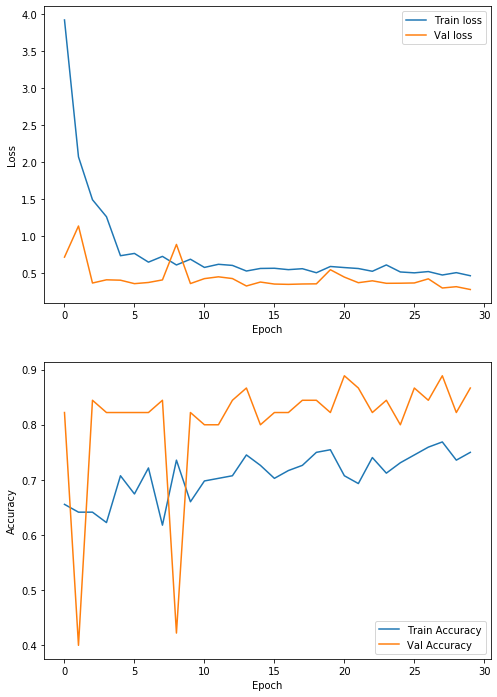

In [13]:
# Previous Unfiltered Data 'MSE' And 'MAE'
def plot_history(history, idx):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'][idx:], hist['loss'][idx:],
           label='Train loss')
    plt.plot(hist['epoch'][idx:], hist['val_loss'][idx:],
           label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'][idx:], hist['accuracy'][idx:],
           label='Train Accuracy')
    plt.plot(hist['epoch'][idx:], hist['val_accuracy'][idx:],
           label = 'Val Accuracy')
    plt.legend()
    plt.show()
    
plot_history(hist,0)

# Model Evaluation

In [14]:
loss, accuracy = model.evaluate(test_ds)
print("Loss is", loss, "\nAccuracy is", accuracy)

10/10 [==============================] - 0s 1ms/step - loss: 0.4822 - accuracy: 0.7609
Loss is 0.4822315525263548 
Accuracy is 0.76086956


# Save the Model

In [15]:
model.save('./models/table_classification.h5')

# Load the model parameter

In [16]:
model2 = Dense_net(input_shape)
model2.load_weights('./models/table_classification.h5')

model2.compile(loss='categorical_crossentropy',
             optimize = adam,
              metrics=['accuracy'])
loss, accuracy = model2.evaluate(test_ds)
print("Loss is", loss, "\nAccuracy is", accuracy)

10/10 [==============================] - 0s 8ms/step - loss: 3.8147e-08 - accuracy: 0.7609
Loss is 3.814697606685513e-08 
Accuracy is 0.76086956
